### Importing the necessary Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os

### Setting the parameters

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load files from the Kraggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eye-diseases-classification


In [ ]:
folder_path = '/kaggle/input/eye-diseases-classification/dataset'

In [ ]:
for files in os.listdir(folder_path):
  print(files)

glaucoma
normal
diabetic_retinopathy
cataract


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4217 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names

In [ ]:
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
len(dataset)

132

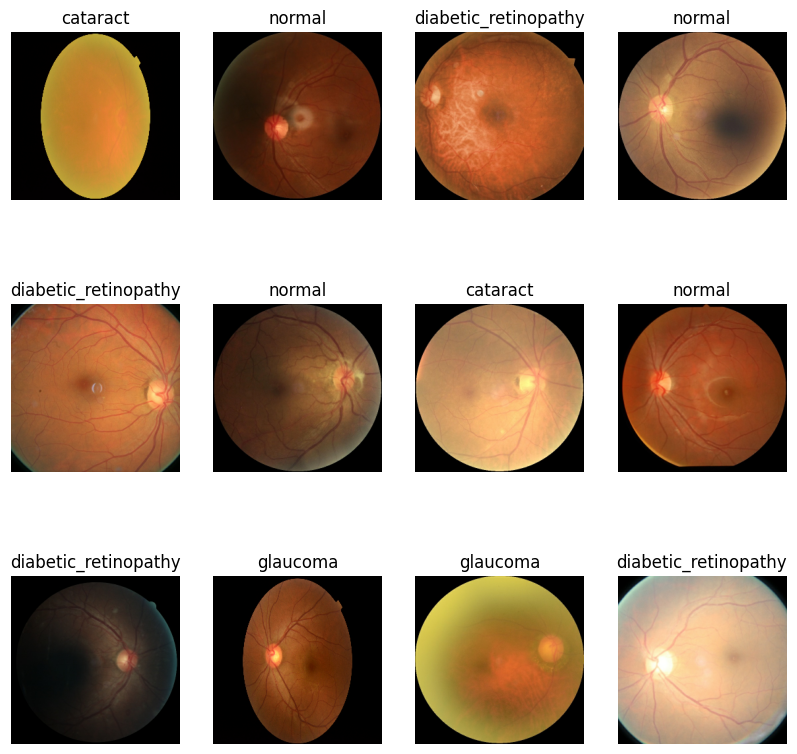

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size  = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size  = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size) # Corrected skip for test_ds

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

105

In [ ]:
len(val_ds)

13

In [ ]:
len(test_ds)

14

In [ ]:
trains_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Rescaling and Resizing


In [ ]:
from tensorflow.keras import layers, models

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
base_model = VGG16(weights = 'imagenet',include_top = False, input_shape = input_shape)
for layer in base_model.layers:
  layer.trainable = False
  x = Flatten()(base_model.output)
  x = Dense(128, activation='relu')(x)
  output = Dense(n_classes, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=output)
  model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_115 (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,909,636 (72.13 MB)

 Trainable params: 4,194,948 (16.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
print(input_shape)

(256, 256, 3)


In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 75s 375ms/step - accuracy: 0.7000 - loss: 9.2249 - val_accuracy: 0.8774 - val_loss: 0.4141
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 242ms/step - accuracy: 0.9069 - loss: 0.4751 - val_accuracy: 0.9183 - val_loss: 0.3052
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 81s 256ms/step - accuracy: 0.9472 - loss: 0.5468 - val_accuracy: 0.9639 - val_loss: 0.0993
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 243ms/step - accuracy: 0.9574 - loss: 0.1793 - val_accuracy: 0.9784 - val_loss: 0.0617
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.9720 - loss: 0.0864 - val_accuracy: 0.9856 - val_loss: 0.0357
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.9871 - loss: 0.0594 - val_accuracy: 0.9952 - val_loss: 0.0126
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 85s 252ms/step - accuracy: 0.9889 - loss: 0.0375 - val_accuracy: 0.9784 - val_loss: 0.0683
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 79s 250ms/step - accuracy: 0.9864 - loss: 0

In [ ]:
score= model.evaluate(test_ds)
#

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.9978 - loss: 0.0439


In [ ]:
score

[0.044936325401067734, 0.9977678656578064]

### Saving the Entire Trained Model

In [ ]:
model.save('my_model.keras')

In [ ]:
new_model = tf.keras.models.load_model('my_model.keras')
new_model.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_115 (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,299,534 (104.14 MB)

 Trainable params: 4,194,948 (16.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 8,389,898 (32.00 MB)

### Accuracy and Loss Visualization

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 105}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.7927229404449463,
 0.9102296233177185,
 0.9446428418159485,
 0.9586309790611267,
 0.968982994556427,
 0.9824038147926331,
 0.9889650940895081,
 0.9910528063774109,
 0.9973158240318298,
 0.9982105493545532]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
val_acc

[0.8774038553237915,
 0.9182692170143127,
 0.963942289352417,
 0.9783653616905212,
 0.9855769276618958,
 0.995192289352417,
 0.9783653616905212,
 0.9975961446762085,
 1.0,
 0.9975961446762085]

In [ ]:
loss

[3.9707934856414795,
 0.45068076252937317,
 0.32691022753715515,
 0.16840849816799164,
 0.09868083149194717,
 0.06791894882917404,
 0.04956148564815521,
 0.03396015986800194,
 0.008957253769040108,
 0.01823521964251995]

In [ ]:
val_loss

[0.4140892028808594,
 0.30518415570259094,
 0.09930642694234848,
 0.0616697333753109,
 0.03565249219536781,
 0.012588505633175373,
 0.06828866899013519,
 0.006285701412707567,
 0.003913387190550566,
 0.005552682094275951]

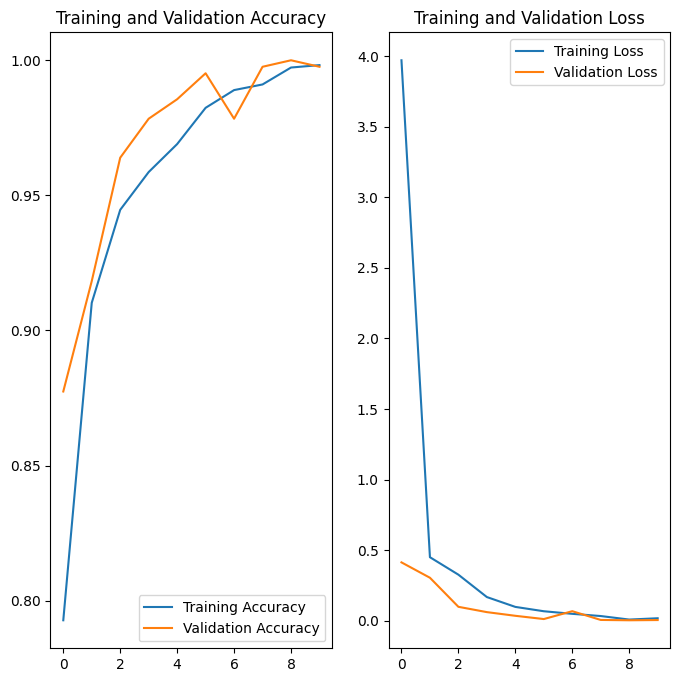

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss , label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Prediction

first image to predict
first image actual label: diabetic_retinopathy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
predicted label: diabetic_retinopathy


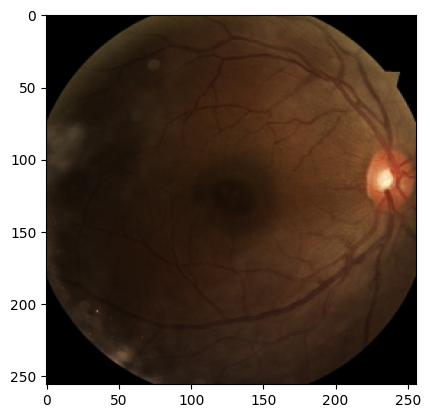

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print('first image actual label:',class_names[first_label])

    batch_prediction = new_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

### Model Prediction with Confidence Scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


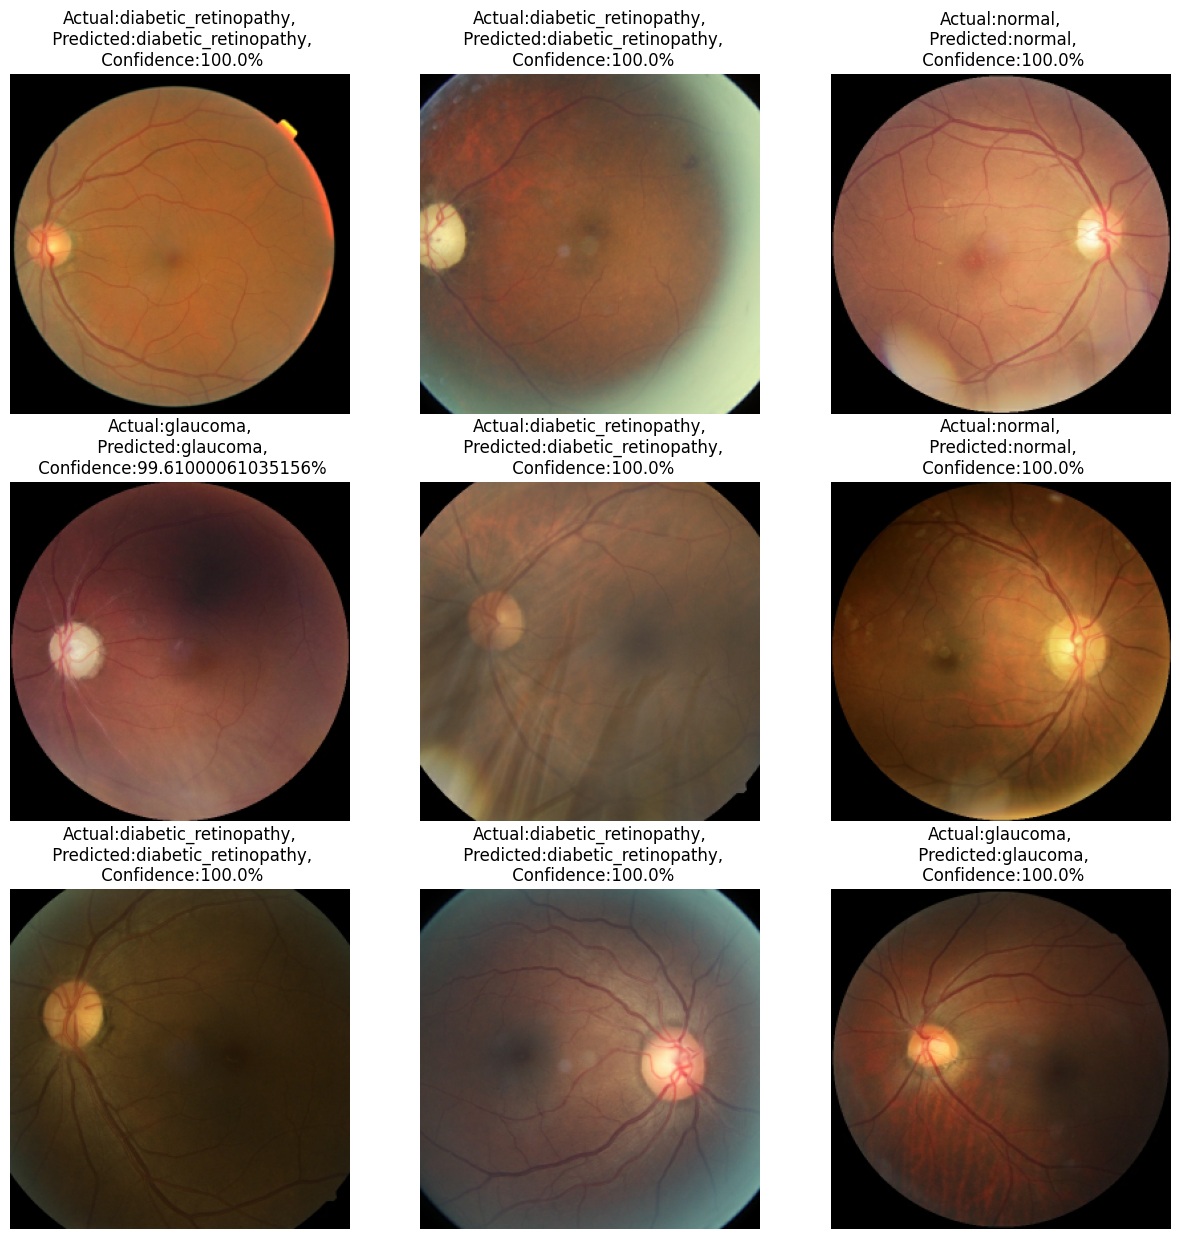

In [ ]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")

    plt.axis('off')

### Model saving and versioning